In [1]:
# Importing necessary Libraries
import pandas as pd #for handling CSV data
import torch
from torch.utils.data import Dataset, DataLoader # for batching the data
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score
from transformers import DistilBertTokenizer, DistilBertModel
from torch.optim import AdamW
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# Mount Drive for the dataset and to save the model
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the IMDB review Dataset
file_path = '/content/drive/MyDrive/Year2_Assignment_2/IMDBDataset.csv' # path to csv
df = pd.read_csv(file_path)
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0}) # Labeling the sentiment to values 1 and 0

In [4]:
# Setting a set random seed throughout for reproducability
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED) # set seed for pytorch on cpu
torch.cuda.manual_seed_all(SEED) # set seed for GPU using CUDA

In [5]:
# Train-Test Split (80% - 20%)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'].values, df['label'].values, test_size=0.2, random_state=SEED)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.1, random_state=SEED)

In [6]:
# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased') # loading of the BERT tokenizer

# Dataset Class
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [7]:
# DataLoaders
train_dataset = IMDBDataset(train_texts, train_labels, tokenizer)
val_dataset = IMDBDataset(val_texts, val_labels, tokenizer)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True) # shuffling the train data
val_loader = DataLoader(val_dataset, batch_size=16, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, num_workers=2, pin_memory=True)

In [8]:
# Model
class SentimentClassifier(nn.Module):
    def __init__(self, dropout=0.3):
        super(SentimentClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.bert.config.hidden_size, 2)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        return self.classifier(cls_output)

In [9]:
# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier().to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler()

# Lists for tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/tmp/ipython-input-3407565765.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [10]:
# Training Loop
EPOCHS = 3
for epoch in range(EPOCHS):
    # Training
    model.train()
    total_loss, correct, total = 0, 0, 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

/tmp/ipython-input-116813620.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


In [11]:
    # Validation
    model.eval()
    total_val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            total_val_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")


Epoch 3/3 | Train Loss: 0.1155, Acc: 0.9571 | Val Loss: 0.3417, Acc: 0.8792


In [12]:
#Final Test Evaluation
model.eval()
preds, true = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        _, predicted = torch.max(outputs, dim=1)
        preds.extend(predicted.cpu().numpy())
        true.extend(labels.cpu().numpy())

test_acc = accuracy_score(true, preds)
test_f1 = f1_score(true, preds)
print(f"\n✅ Final Test Accuracy: {test_acc:.4f}, F1 Score: {test_f1:.4f}")


✅ Final Test Accuracy: 0.8762, F1 Score: 0.8733


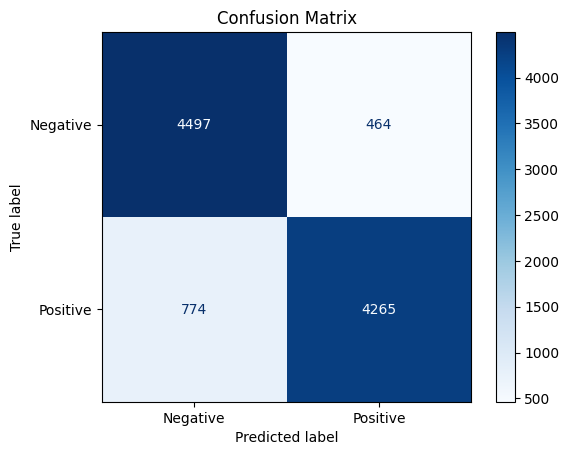

In [13]:
# Confusion Matrix
cm = confusion_matrix(true, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [14]:
# Save model + tokenizer
model_save_path = "/content/drive/MyDrive/Year2_Assignment_2/distilbert_sentiment_model"
tokenizer.save_pretrained(model_save_path)
torch.save(model.state_dict(), f"{model_save_path}/model.pt")

In [15]:
# Prediction Function
def predict_sentiment(model, tokenizer, sentence, max_len=128):
    model.eval()
    encoding = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted_class = torch.max(probs, dim=1)
    label = 'Positive' if predicted_class.item() == 1 else 'Negative'
    return label, confidence.item()

In [22]:
# Lets try with your own sentence
my_sentence = "The movie could have been better, but i loved it."
pred_label, pred_confidence = predict_sentiment(model, tokenizer, my_sentence)
print(f"\nSentence: {my_sentence}\nPredicted sentiment: {pred_label} (Confidence: {pred_confidence:.4f})")


Sentence: The movie could have been better but i loved it.
Predicted sentiment: Positive (Confidence: 0.9954)


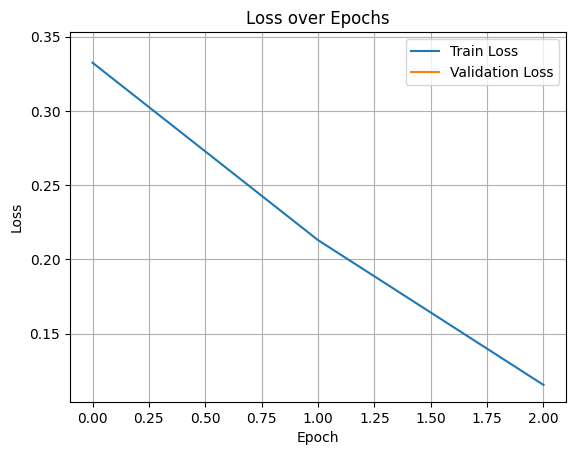

In [17]:
# Plot Loss & Accuracy
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

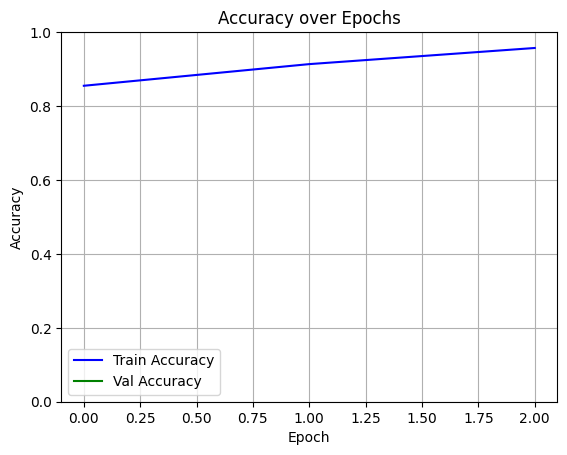

In [18]:
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Val Accuracy', color='green')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()